# Solving Graph Coloring Via Reduction To SAT (Gate Model)

## Processing the graph 

We will process a graph saved under [DIMACS Graph Coloring Format](https://mat.tepper.cmu.edu/COLOR/instances.html). 

In [375]:
def read_graph(name):
    num_vertices = 0
    num_edges = 0 
    list_edges = []
    file = open("data/" + name , "r")
    for line in file:
        tokens = line.split()
        if(tokens[0] == "c"):
            #this line is a comment
            continue
        elif(tokens[0] == "p"and tokens[1] == "edge"):
            # save number of vertices and edges
            num_vertices = tokens[2]
            num_edges = tokens[3]
        else:
            # this is a line describing an edge
            temp = [int(tokens[1]), int(tokens[2])]
            list_edges.append(temp)
    file.close()
    return int(num_vertices), int(num_edges), list_edges
    

In [398]:
num_vertices, num_edges, list_edges = read_graph("graph3.txt")

In [399]:
print(num_vertices, num_edges, list_edges)

3 0 []


## Reducing to SAT

We will use the [DIMACS CNF Formula](http://www.satcompetition.org/2009/format-benchmarks2009.html) to represent boolean formulas.

In [380]:
def reduce_to_SAT(nv, ne, ledges, k_colors):
    
    def get_vertex_color_repr(vertex):
        temp = list()
        for i in range (k_colors):
            temp.append(str(k_colors*vertex - i))
        return temp
    
    
    def get_vertex_contraints(vertex):
        constraints = []
        vertex_color_repr = get_vertex_color_repr(vertex)
        temp = ""
        # select at least one color
        for c in vertex_color_repr: 
            temp += str(c) + " "
        
        temp+="0"
        constraints.append(temp);
        
        #select at most one color
        for c1 in range(len(vertex_color_repr)):
            for c2 in range(c1+1, len(vertex_color_repr)):
                temp = "-" + str(c1+1) + " -" + str(c2+1) + " 0"
                constraints.append(temp)
        return constraints
    
    
    def get_edge_constraints(v1, v2):
        constraints = []
        v1_color_repr = get_vertex_color_repr(v1)
        v2_color_repr = get_vertex_color_repr(v2)
        
        for i in range(len(v1_color_repr)):
            constraints.append("-" + str(v1_color_repr[i]) + " -" + str(v2_color_repr[i]) + " 0")
        return constraints
                
    buffer = []
    
    buffer.append("p cnf " + str(nv*k_colors) + " " + str(ne*k_colors + nv*int(1 +( k_colors * (k_colors-1) )/2 ) ))
    
    for i in range(1, nv+1):
        buffer.extend(get_vertex_contraints(i))
    
    for e in ledges:
        buffer.extend(get_edge_constraints(e[0], e[1]))
    return '\n'.join(buffer)

In [400]:
cnf_SAT = reduce_to_SAT(num_vertices, num_edges, list_edges, 1)

In [401]:
print(cnf_SAT)

p cnf 3 3
1 0
2 0
3 0


# Grover Algorithm

In [183]:
from qiskit import *
from qiskit.providers.aer import QasmSimulator

- aux: registros para las ancilas, en donde se guardara el resultado de cada clausula para luego aplicar un AND
    - aux_vertex1: su longitud va a ser igual a nv porque para asegurarnos que un vertice solo tenga un color vamos a almacenar la clausula de dicho vertice en una ancila (just one color)
    - aux_vertex2: escoger a lo mucho un color
        - (self.k_colors * (self.k_colors-1)): numero de clausulas por cada vertice dado k_colores
    - aux_edges: vertices adyacentes no pueden tener el mismo color
        - self.k_colors*ne : ver todos los colores por cada arista
- q_registers: registros cuáticos
    - primeros nv*k_colors registros cuanticos: representan la configuración de color de cada vertices y se agrupan en conjuntos de longitud k_colors
- c_registers: classical registers
- y: oracle function output

In [406]:
from math import sqrt, factorial
class GroverAlgorithm:
    
    def __init__(self,nv, ne, listedges, k_colors):
        self.nv = nv
        self.ne=ne
        self.listedges = listedges
        self.k_colors = k_colors
        self.q_registers = []
        self.c_registers = []
        self.controls = []
        self.target = None
        for i in range(nv):
            self.q_registers.append(QuantumRegister(k_colors, "v"+str(i+1) + str(i % k_colors))) #append k_colors qubits for each vertex
            self.c_registers.append(ClassicalRegister(k_colors, "c" + str(i+1)+ str(i % k_colors))) #append k_colors qubits for each 
                                                                                 #vertex so we can measure each of
                                                                                 #k_colors qubits into a classical 
                                                                                 #into a classical register
            for j in range(self.k_colors):
                self.controls.append(self.q_registers[i][j])
        #self.controls = self.q_registers[0]
        self.aux_vertex1 = QuantumRegister(self.nv, "a.v1") #per vertex clauses ancillas (just one color)
        self.aux_vertex2 = [] #per vertex clauses ancillas (at most one color)
        
        for i in range(nv):
            self.aux_vertex2.append(QuantumRegister(self.k_colors * (self.k_colors-1)-1, "a.v2"+str(i)))
        
        self.aux_edges =[] 
        for i in range(ne):
            self.aux_edges.append(QuantumRegister(self.k_colors, "a.e"+ str(i)))
        
        self.y = QuantumRegister(1, "y")
        self.target = self.y
        self.q_registers.append(self.y)
        
        #add ancillas
        self.q_registers.append(self.aux_vertex1)
        self.q_registers.extend(self.aux_vertex2) #TEST
        self.q_registers.extend(self.aux_edges)
        
        #create circuit and add registers

        self.circuit = QuantumCircuit()
        
        for r in self.q_registers:
            self.circuit.add_register(r)
            
        for r in self.c_registers:
            self.circuit.add_register(r)
    
    def initialize_system(self):
        #initialize all except for ancillas and y in supoerposition
        for i in range(self.nv):
            for j in range(self.k_colors):
                self.circuit.h(self.q_registers[i][j])
                
        #for y: set to 1 and then apply hadmard gate
        self.circuit.x(self.y)
        self.circuit.h(self.y)
        self.circuit.barrier()
        
    def oracle(self):
        self.circuit.barrier()
        # vertex constraints
        
        for vertex in range(self.nv):
            for color in range(self.k_colors):
                self.circuit.cx(self.q_registers[vertex][color], self.aux_vertex1[vertex])
        
        for  vertex in range(self.nv):
            for color in range(self.k_colors):
                 self.circuit.x(self.q_registers[vertex][color])
        for vertex in range(self.nv):
            for color in range(self.k_colors-1):
                for k in range(color+1, self.k_colors):
                    self.circuit.cx(self.q_registers[vertex][color], self.aux_vertex2[vertex][color*self.k_colors + k -1])
                    self.circuit.cx(self.q_registers[vertex][k], self.aux_vertex2[vertex][color*self.k_colors + k-1])
        

        #edge constraints
        
        for edge in range(len(self.listedges)):
            self.circuit.x(self.q_registers[self.listedges[edge][0]-1])
            self.circuit.x(self.q_registers[self.listedges[edge][1]-1])
            for color in range(self.k_colors):
                self.circuit.cx(self.q_registers[self.listedges[edge][0]-1][color],self.aux_edges[edge][color])
                self.circuit.cx(self.q_registers[self.listedges[edge][1]-1][color],self.aux_edges[edge][color])
            self.circuit.x(self.q_registers[self.listedges[edge][0]-1]) #reverse
            self.circuit.x(self.q_registers[self.listedges[edge][1]-1]) #reverse
        
        
        #see if all clauses are true
        self.circuit.ccx(self.aux_vertex1[0], self.aux_vertex2[0], self.y[0])
        #self.circuit.append(self.multi_cx, self.multix_list)
        for vertex in range(self.nv):
            for color in range(self.k_colors-1):
                for k in range(color+1, self.k_colors):
                    self.circuit.cx(self.q_registers[vertex][color], self.aux_vertex2[vertex][color*self.k_colors + k -1])
                    self.circuit.cx(self.q_registers[vertex][k], self.aux_vertex2[vertex][color*self.k_colors + k-1])
        #reverse negative literals
        for  vertex in range(self.nv):
            for color in range(self.k_colors):
                 self.circuit.x(self.q_registers[vertex][color])
        self.circuit.barrier()
        '''
        self.circuit.reset(self.aux_vertex1)
        for qr in self.aux_vertex2:
            self.circuit.reset(qr) 
        for qr in self.aux_edges:
            self.circuit.reset(qr)'''
      
        
    def n_controlled_Z(self):
        if (len(self.controls) > 2):
            raise ValueError('The controlled Z with more than 2 controls is not implemented')
        elif (len(self.controls) == 1):
            self.circuit.h(self.target)
            self.circuit.cx(self.controls[0], self.target)
            self.circuit.h(self.target)
        elif (len(self.controls) == 2):
            self.circuit.h(self.target)
            self.circuit.ccx(self.controls[0], self.controls[1], self.target)
            self.circuit.h(self.target)
        
    def inversion_above_average(self):
        self.circuit.barrier()
        for i in range(self.nv):
            for j in range(self.k_colors):
                self.circuit.h(self.q_registers[i][j])  
        for i in range(self.nv):
            for j in range(self.k_colors):
                self.circuit.x(self.q_registers[i][j]) 
        self.n_controlled_Z()
        #self.circuit.h(self.y)
        #self.circuit.ccx(self.q_registers[0][0], self.q_registers[0][1], self.y)
        #self.circuit.h(self.y)
        for i in range(self.nv):
            for j in range(self.k_colors):
                self.circuit.x(self.q_registers[i][j]) 
        for i in range(self.nv):
            for j in range(self.k_colors):
                self.circuit.h(self.q_registers[i][j])  
        self.circuit.barrier()
                
    def measure(self):
        for i in range(self.nv):
            for j in range(self.k_colors):
                self.circuit.measure(self.q_registers[i][j], self.c_registers[i][j])
                
    def build_circuit(self):
        self.initialize_system()
        for i in range(self.k_colors**self.nv):
            self.oracle()
            self.inversion_above_average()
        self.measure()
        return self.circuit
    
    def run(self):
        self.build_circuit()
        result = execute(self.circuit, QasmSimulator(), shots=2048).result()
        return result

In [407]:
ga = GroverAlgorithm(num_vertices, num_edges, list_edges,2)
result = ga.run()

ValueError: The controlled Z with more than 2 controls is not implemented

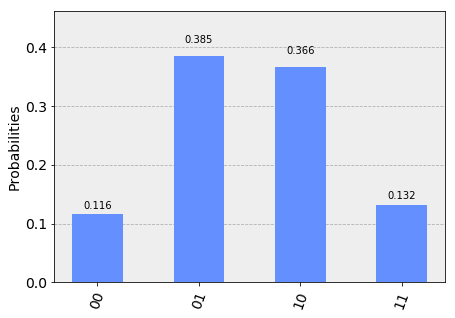

In [366]:
# import basic plot tools
from qiskit.tools.visualization import plot_histogram
answer = result.get_counts()
plot_histogram(answer)

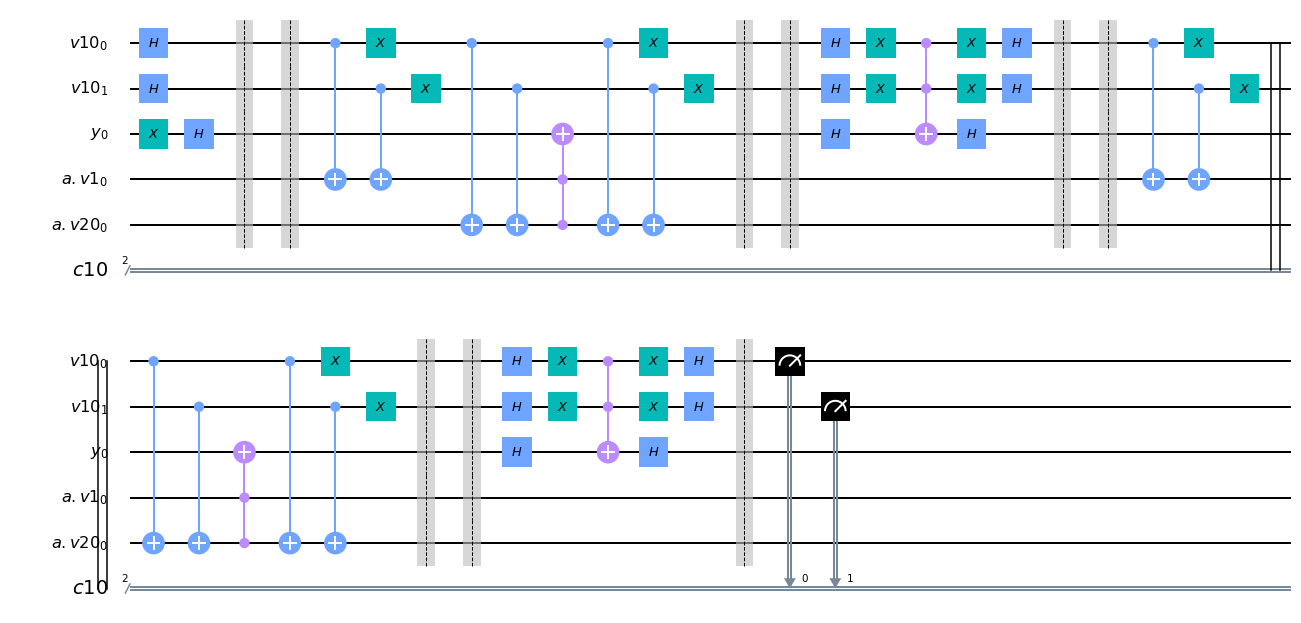

In [357]:
ga.circuit.draw(output="mpl")

In [402]:
import numpy as np
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import QuantumInstance, run_algorithm
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle

In [403]:
oracle = LogicalExpressionOracle(cnf_SAT)
grover = Grover(oracle)

In [404]:
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=2048)
result = grover.run(quantum_instance)
print(result['result'])

[1, 2, 3]


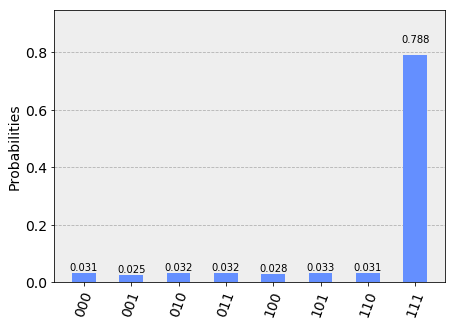

In [405]:
plot_histogram(result['measurement'])

In [278]:
ga = GroverAlgorithm2(num_vertices, num_edges, list_edges,2)
result = ga.run()

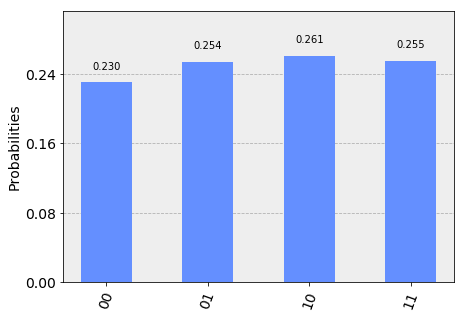

In [279]:
answer = result.get_counts()
plot_histogram(answer)